<h1>MNIST_Recognizer_CNN<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preparation</a></span><ul class="toc-item"><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load data</a></span></li><li><span><a href="#Split-into-Target-and-Features" data-toc-modified-id="Split-into-Target-and-Features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split into Target and Features</a></span></li><li><span><a href="#Check-for-null-and-missing-values" data-toc-modified-id="Check-for-null-and-missing-values-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Check for null and missing values</a></span></li><li><span><a href="#Normalize-data" data-toc-modified-id="Normalize-data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Normalize data</a></span></li><li><span><a href="#Reshape" data-toc-modified-id="Reshape-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Reshape</a></span></li><li><span><a href="#Encode-target" data-toc-modified-id="Encode-target-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Encode target</a></span></li><li><span><a href="#Split-into-train-and-validation-set" data-toc-modified-id="Split-into-train-and-validation-set-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Split into train and validation set</a></span></li></ul></li><li><span><a href="#Modeling-(Ensemble-of-5-CNN)" data-toc-modified-id="Modeling-(Ensemble-of-5-CNN)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling (Ensemble of 5 CNN)</a></span><ul class="toc-item"><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Data-augmentation" data-toc-modified-id="Data-augmentation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Data augmentation</a></span></li></ul></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#Training-and-validation-curves" data-toc-modified-id="Training-and-validation-curves-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Training and validation curves</a></span></li><li><span><a href="#Confusion-matrix" data-toc-modified-id="Confusion-matrix-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Confusion matrix</a></span></li><li><span><a href="#Explore-the-errors" data-toc-modified-id="Explore-the-errors-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Explore the errors</a></span></li></ul></li><li><span><a href="#Prediction" data-toc-modified-id="Prediction-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prediction</a></span></li></ul></div>

# Importing libraries

In [1]:
#Basic 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')

np.random.seed(9)

In [2]:
#Specific

import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf

from keras.utils.np_utils import to_categorical #convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LearningRateScheduler


Using TensorFlow backend.


In [3]:
#GPU testing 

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
print(tf.test.is_built_with_cuda())

Default GPU Device: /device:GPU:0
True


# Data Preparation 

## Load data 

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

## Split into Target and Features

In [5]:
y_train=train['label']
X_train=train.drop(columns='label')

In [6]:
# free some space
del train 

Check balance in the target varible

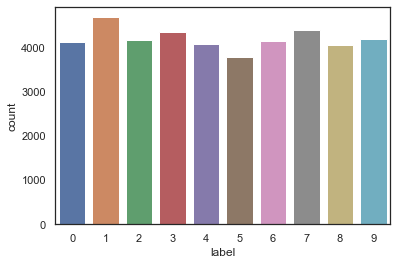

In [7]:
sns.countplot(y_train)

The dataset is balanced

## Check for null and missing values

In [8]:
X_train.isna().any().sum()

0

In [9]:
test.isna().any().sum()

0

## Normalize data

In [10]:
X_train /=255.0
test /=255.0

## Reshape

In [11]:
X_train=X_train.values.reshape(-1,28,28,1)
test=test.values.reshape(-1,28,28,1)

## Encode target

In [12]:
#Cross-entropy loss needs OHE for target
y_train=to_categorical(y_train,num_classes=10)

## Split into train and validation set

In [13]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size = 0.25, random_state=2)

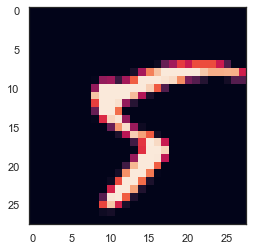

In [14]:
plt.imshow(X_train[0][:,:,0])

In [15]:
X_train.shape

(31500, 28, 28, 1)

# Modeling (Ensemble of 5 CNN)

## Define the model

In [23]:
nets=5
model=[0]*nets

for i in range(nets):
    model[i]=Sequential()
    
    model[i].add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(28,28,1)))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(32, kernel_size =(5,5), strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))
    
    model[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[i].add(BatchNormalization())
    model[i].add(Dropout(0.4))
    
    model[i].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[i].add(BatchNormalization())
    
    model[i].add(Flatten())
    model[i].add(Dropout(0.4))
    model[i].add(Dense(10,activation='softmax'))
    
    model[i].compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'] )
    

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [18]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

## Data augmentation

In [20]:
# With data augmentation to prevent overfitting:
datagen = ImageDataGenerator(
          featurewise_center=False,            # set input mean to 0 over the dataset
          samplewise_center=False,             # set each sample mean to 0
          featurewise_std_normalization=False, # divide inputs by std of the dataset
          samplewise_std_normalization=False,  # divide each input by its std
          zca_whitening=False,                 # apply ZCA whitening
          rotation_range=10,                   # randomly rotate images in the range (degrees, 0 to 180)
          zoom_range = 0.1,                    # Randomly zoom image 
          width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
          height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
          horizontal_flip=False,               # randomly flip images
          vertical_flip=False)                 # randomly flip images

datagen.fit(X_train)

In [21]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)

In [24]:
# train the network
history = [0] * nets
epochs = 30
for j in range(nets):
    print("CNN ",j+1)
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=1)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['accuracy']),max(history[j].history['val_accuracy']) ))

CNN  1
Epoch 1/30
442/442 [==============================] - 54s 123ms/step - loss: 0.5918 - accuracy: 0.8159 - val_loss: 0.8902 - val_accuracy: 0.7162
Epoch 2/30
442/442 [==============================] - 53s 120ms/step - loss: 0.1661 - accuracy: 0.9494 - val_loss: 0.0593 - val_accuracy: 0.9787
Epoch 3/30
442/442 [==============================] - 52s 119ms/step - loss: 0.1129 - accuracy: 0.9662 - val_loss: 0.0465 - val_accuracy: 0.9848
Epoch 4/30
442/442 [==============================] - 53s 119ms/step - loss: 0.0991 - accuracy: 0.9710 - val_loss: 0.0340 - val_accuracy: 0.9902
Epoch 5/30
442/442 [==============================] - 54s 122ms/step - loss: 0.0844 - accuracy: 0.9744 - val_loss: 0.0431 - val_accuracy: 0.9863
Epoch 6/30
442/442 [==============================] - 54s 121ms/step - loss: 0.0748 - accuracy: 0.9771 - val_loss: 0.0402 - val_accuracy: 0.9876
Epoch 7/30
442/442 [==============================] - 53s 121ms/step - loss: 0.0685 - accuracy: 0.9791 - val_loss: 0.0278 -

442/442 [==============================] - 52s 118ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0165 - val_accuracy: 0.9962
Epoch 27/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0268 - accuracy: 0.9918 - val_loss: 0.0141 - val_accuracy: 0.9965
Epoch 28/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0233 - accuracy: 0.9926 - val_loss: 0.0161 - val_accuracy: 0.9956
Epoch 29/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0226 - accuracy: 0.9930 - val_loss: 0.0217 - val_accuracy: 0.9949
Epoch 30/30
442/442 [==============================] - 53s 119ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.0154 - val_accuracy: 0.9962
CNN 2: Epochs=30, Train accuracy=0.99300, Validation accuracy=0.99778
CNN  3
Epoch 1/30
442/442 [==============================] - 55s 124ms/step - loss: 0.5400 - accuracy: 0.8343 - val_loss: 4.1139 - val_accuracy: 0.3025
Epoch 2/30
442/442 [==============================] - 52s 11

442/442 [==============================] - 52s 118ms/step - loss: 0.0302 - accuracy: 0.9910 - val_loss: 0.0207 - val_accuracy: 0.9933
Epoch 22/30
442/442 [==============================] - 52s 119ms/step - loss: 0.0293 - accuracy: 0.9911 - val_loss: 0.0221 - val_accuracy: 0.9933
Epoch 23/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0278 - accuracy: 0.9917 - val_loss: 0.0230 - val_accuracy: 0.9933
Epoch 24/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0266 - accuracy: 0.9919 - val_loss: 0.0189 - val_accuracy: 0.9946
Epoch 25/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0267 - accuracy: 0.9922 - val_loss: 0.0238 - val_accuracy: 0.9908
Epoch 26/30
442/442 [==============================] - 52s 118ms/step - loss: 0.0277 - accuracy: 0.9920 - val_loss: 0.0239 - val_accuracy: 0.9933
Epoch 27/30
442/442 [==============================] - 52s 119ms/step - loss: 0.0246 - accuracy: 0.9926 - val_loss: 0.0206 - val_accurac

In [38]:
#make the ensemble prediction on the validation set
results_ens = np.zeros( (X_val2.shape[0],10) ) 
for j in range(nets):
    results_ens = results_ens + model[j].predict(X_val2)
results_ens = np.argmax(results_ens,axis =1)

In [48]:
#get the score of the ensemble prediction
from sklearn.metrics import accuracy_score

Y_val2=np.argmax(Y_val2,axis =1)
ens_acc=accuracy_score(results_ens,Y_val2)


0.9984126984126984

In [91]:
print('Ensemble accuracy: {:.4f}'.format (ens_acc))

Ensemble accuracy: 0.9984


# Evaluation 

## Training and validation curves

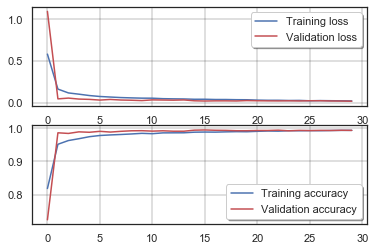

In [49]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history[4].history['loss'], color='b', label="Training loss")
ax[0].plot(history[4].history['val_loss'], color='r', label="Validation loss",axes =ax[0])
ax[0].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history[4].history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history[4].history['val_accuracy'], color='r',label="Validation accuracy")
ax[1].grid(color='black', linestyle='-', linewidth=0.25)
legend = ax[1].legend(loc='best', shadow=True)

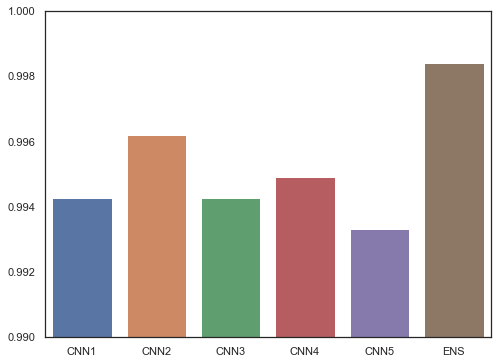

In [80]:
#Vizualization of single CNNs and the ensemble accuracy on validation set 
accs=[]
for i in range (nets):
    accs.append(history[i].history['val_accuracy'][29])
                 
accs.append(ens_acc)
cnns=['CNN1','CNN2','CNN3','CNN4','CNN5','ENS']

fig,ax=plt.subplots(figsize=(8,6))
ax=sns.barplot(x=cnns,y=accs)
ax.set(ylim=(0.99, 1.0))

plt.show()

# Prediction

In [38]:
#predict the labels of the test 
results = np.zeros( (test.shape[0],10) ) 
for j in range(nets):
    results = results + model[j].predict(test)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("predictions.csv",index=False)